<a href="https://colab.research.google.com/github/rewachauhan/Gland-Image-Segmentation-in-Digital-Pathology/blob/master/miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#loading the dataset present on my drive



In [17]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
!ls {'/content/gdrive/"My Drive"/data'}

test  testR  train


#importing the required libraries/modules

In [0]:
import os
import numpy as np
from skimage.transform import resize
from skimage.io import imread, imshow 
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

#defining global variables for resized image and it's directory path


In [0]:
image_rows=128
image_cols=128

data_path='/content/gdrive/My Drive/data'

#importing image(img acquisition), preprocessing and storage for training images

In [0]:
def create_train_data():
  train_data_path=os.path.join(data_path,"train")
  images=os.listdir(train_data_path)
  total=len(images)//2
  imgs=np.zeros((total,image_rows,image_rows,3),dtype=np.uint8)
  imgs_mask=np.zeros((total,image_rows,image_rows,1),dtype=np.bool)
  print("creating training images")
  i=0
  for img_name in images:
    if("anno" in img_name):
      continue
    img_mask_name=img_name.split(".")[0] + "_anno.bmp"
    img=imread(os.path.join(train_data_path,img_name))[:,:,:3]  #since the image will be read as a NumPy array; it'll store the [rows, cols, channels] into the img variable; ':' b/c we need the entire height and width of the image 
    img=resize(img,(image_cols,image_rows),mode="constant",preserve_range=True)  #true b/c after resizing,it must not change the dimension of the img i.e even if the color of the picture is bnw the dimension won't be changed to [128,128,1], it'll be preserved as [128,128,3]
    mask=np.zeros((image_rows,image_rows,1),dtype=np.bool)
    img_mask=imread(os.path.join(train_data_path,img_mask_name)) #since the image will be read as a NumPy array; it'll store the [rows, cols, channels] into the img variable; ':' b/c we need the entire height and width of the image 
    img_mask=np.expand_dims(resize(img_mask,(image_cols,image_rows),mode="constant",preserve_range=True),axis=-1) #we insert a new axis ; -1=last index(python); first, we are resizing the mask image to 128*128*1[as initialized earlier], then we are wrapping it in expand_dims to expand the dim from 1 to 3, else it'll give error while multiplying 
    img_mask=np.maximum(img_mask,mask) #we are comparing each pixel of img_mask to the corresponding pixel in mask; since all values in mask are zeros, therefore, any pixel with negative intensity would be rejected and replaced with 0; hence, we are choosing the darker pixel
   
    imgs[i]=img
    imgs_mask[i]=img_mask

    print(i,"/",total,"read")
    i+=1

  np.save("imgs_train.npy",imgs)
  np.save("imgs__mask_train.npy",imgs_mask)
  print("done")



#importing image(img acquisition), preprocessing and storage for test images

In [0]:
def create_test_data():
  test_data_path=os.path.join(data_path,"test")
  images=os.listdir(test_data_path)               #no mask is needed for test data
  total=len(images)//2
  imgs=np.zeros((total,image_rows,image_rows,3),dtype=np.uint8)
  print("creating test images")
  i=0
  for img_name in images:
    if("anno" in img_name):
      continue
    img=imread(os.path.join(test_data_path,img_name))[:,:,:3]  
    img=resize(img,(image_cols,image_rows),mode="constant",preserve_range=True)  
    
    imgs[i]=img
    
    print(i,"/",total,"read")
    i+=1
 
  np.save("imgs_test.npy",imgs)
  print("done")

#helper function for loading saved data

In [0]:
def load_train_data():
  imgs_train=np.load("imgs_train.npy")
  imgs_mask_train=np.load("imgs__mask_train.npy")
  return imgs_train,imgs_mask_train

def load_test_data():
  imgs_test=np.load("imgs_test.npy")
  return imgs_test

# if (__name__=="__main__") :
#   create_train_data()
#   create_test_data()

#defining default batch size for sending images into the training model in one go

In [0]:
stack=10

#creation of the UNet architecture

In [0]:
def create_model():

  #defining the input layer
  inputs=tf.keras.layers.Input((image_rows,image_cols,3))  #defining the input layer with same dimension as images stored(forming a convolutional layer)
  normalize=tf.keras.layers.Lambda(lambda x:x/255)(inputs) #normalizing the values for making the calculation efficient; max val of pixel=255, now each pixel=x, we're dividing each pixel by 255 for getting the value in between 0 and 1; inputs is the data on which it's working
                                                           #lambda like an inline function that allows us to perform multi-line functions in a single line; eg// def func(x): return x/255; and it directy works on all the values, therefore,no loop needed

  #contraction path begins(hidden layer)
  c1=tf.keras.layers.Conv2D(16,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(normalize)
  c1=tf.keras.layers.Dropout(0.1)(c1)
  c1=tf.keras.layers.Conv2D(16,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(c1)
  p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

  c2=tf.keras.layers.Conv2D(32,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(p1)
  c2=tf.keras.layers.Dropout(0.1)(c2)
  c2=tf.keras.layers.Conv2D(32,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(c2)
  p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

  c3=tf.keras.layers.Conv2D(64,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(p2)
  c3=tf.keras.layers.Dropout(0.2)(c3)
  c3=tf.keras.layers.Conv2D(64,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(c3)
  p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

  c4=tf.keras.layers.Conv2D(128,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(p3)
  c4=tf.keras.layers.Dropout(0.2)(c4)
  c4=tf.keras.layers.Conv2D(128,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(c4)
  p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

  #base layer after contraction path; base the U-net architecture; the shape of "U"
  base=tf.keras.layers.Conv2D(256,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(p4)
  base=tf.keras.layers.Dropout(0.3)(base)
  base=tf.keras.layers.Conv2D(256,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(base)

  #expansion path begins(hidden layer)
  u1=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2), padding="same")(base) #upsampling
  u1=tf.keras.layers.concatenate([u1,c4])
  
  c5=tf.keras.layers.Conv2D(128,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(u1)
  c5=tf.keras.layers.Dropout(0.2)(c5)
  c5=tf.keras.layers.Conv2D(128,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(c5)  #no max-pooling reqd,since now we are increasing the dimension of the matrix

  u2=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2), padding="same")(c5) #upsampling
  u2=tf.keras.layers.concatenate([u2,c3])
  
  c6=tf.keras.layers.Conv2D(64,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(u2)
  c6=tf.keras.layers.Dropout(0.2)(c6)
  c6=tf.keras.layers.Conv2D(64,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(c6)

  u3=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2), padding="same")(c6) #upsampling
  u3=tf.keras.layers.concatenate([u3,c2])

  c7=tf.keras.layers.Conv2D(32,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(u3)
  c7=tf.keras.layers.Dropout(0.1)(c7)
  c7=tf.keras.layers.Conv2D(32,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(c7)

  u4=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2), padding="same")(c7) #upsampling
  u4=tf.keras.layers.concatenate([u4,c1],axis=3)
  
  c8=tf.keras.layers.Conv2D(16,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(u4)
  c8=tf.keras.layers.Dropout(0.1)(c8)
  c8=tf.keras.layers.Conv2D(16,(3,3), activation="relu", padding="same", kernel_initializer="he_normal")(c8)

  #defining the o/p layer
  outputs=tf.keras.layers.Conv2D(1,(1,1),activation="sigmoid")(c8)  #no padding needed, since the output has to be in a 1D array, therefore, tha filter size is (1X1) i.e. filter is being applied on each pixel b/c the output probability is needed.
  
  #model initialization
  model=tf.keras.Model(inputs=[inputs],outputs=[outputs])           #model is a predefined fun that initializes the model i.e. groups all the layers into one interface/object, once we provide the input layer and the output layer
                                                                    #back propagation, feed-forward, weight changing all of these are implemented inside this function itself
  model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"]) #optimizer-gradient calculation i.e deciding the suitable weight and bias, it also sets the learning rate
                                                                                  #adam=rms+momentum eq
                                                                                  #loss function - diff b/w actual and predicted value; binary cross entropy used since we have only two outputs either boundary or cell
                                                                                  #metric- how much is the output matching with the mask ; accuracy is being checked ; similar to average ; the avg is converted to percentage

  return model




#data loading; model fitting and prediction

In [0]:
def train_and_predict():
  print("loading images")
  imgs_train,imgs_mask_train=load_train_data()
  model=create_model()
  print("data augumentation")
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        horizontal_flip=True,   #to increase the volume of the dataset, we are flipping the dataset. so that one image may generate 5 other images by flipping and rotating the same image
        vertical_flip=True)
        
  total = imgs_train.shape[0]
  img = []
  count = 0
  for batch in datagen.flow(imgs_train, batch_size=1, seed=1337):
      img.append(batch)
      count += 1
      if count > total*stack:
          break
  imgs_train = np.array(img)[:,0]
  mask = [] 
  count = 0
  for batch in datagen.flow(imgs_mask_train, batch_size=1, seed=1337): 
      mask.append(batch)
      count += 1
      if count > total*stack:
          break
  imgs_mask_train = np.array(mask)[:,0]
  callbacks=[
             tf.keras.callbacks.EarlyStopping(patience=5, monitor="loss", verbose=0),  	  #if 5 consecutive epochs give the same accuracy the image would be stopped from being trained any further. 
                                                                                           #monitor=loss i.e the attricbute being checked for similarity is the value of the loss function in the 5 epochs; verbose is used to display the values of the loss fn etc
             tf.keras.callbacks.ModelCheckpoint("weights.h5", monitor="loss", save_best_only=True) #it will create a file 'weights.h5' and store the value of wts and bias from each loss fn of each epoch; at each epoch's completion it compares the stored values in the file of the prev epoch with the current epoch's value and it saves the best result //h5 is the tf's file format 
   ]
  # model.fit(imgs_train,imgs_mask_train,batch_size=stack, epochs=100, callbacks=callbacks, verbose=1)  #now we are sending the input=imgs_train as the first paraeter and the output=imgs_mask_train as the 2nd para; since te model knows the o/p it will try to generate the similar kind of output for the corresponding i/p   
   
  imgs_test=load_test_data()    
  model.load_weights("weights.h5")                       #inbuilt fn to load the wt
  imgs_mask_test=model.predict(imgs_test,verbose=1)     #inbuilt fn; it provides the test images to the neural network through a feed forward path and stores the result obtained
  pred_test=(imgs_mask_test>0.5).astype(np.uint8)       #for pred probability >0.5 in the resultant mask, we are adding this mask to pred_test variable; astype is being used to round off the values as either 0 or 1, else it'll accept values as 0.7 etc
  np.save("imgs_mask_test.npy",pred_test)
  print("done")                                                                 
    

#calling the fn for model training, fitting and prediction

In [44]:
train_and_predict()

loading images
data augumentation
3/3 [==============================] - 1s 188ms/step
done


#visualiztation of test mask

In [0]:
def graph():
  imgs=np.load("imgs_test.npy")
  result=np.load("imgs_mask_test.npy")
  # total=result.shape[0]
  for i in range (5):
    plt.imshow(imgs[i],cmap="Greys")  #cmap=colormapping
    plt.show()
    plt.imshow(np.squeeze(result[i]))
    plt.show()

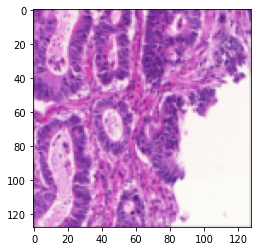

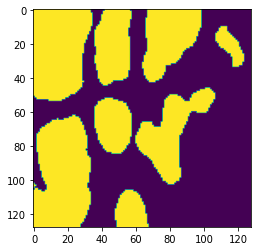

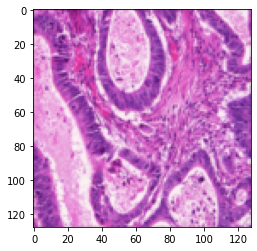

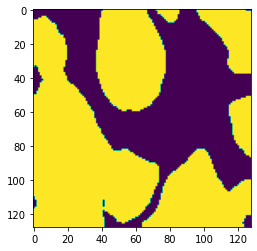

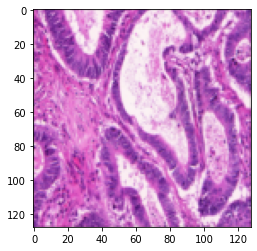

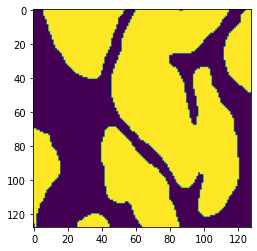

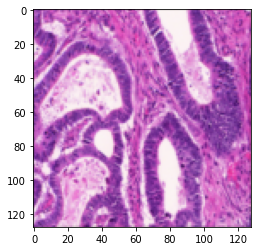

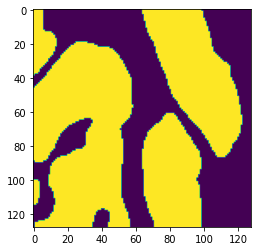

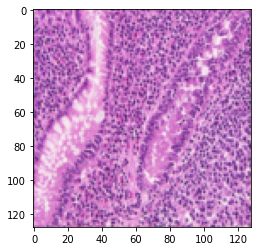

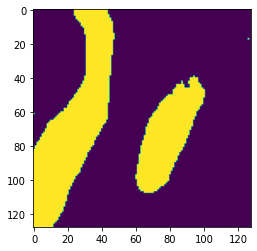

In [46]:
graph()